Here we create an artifical dataset containing data points that are not linearly separable, and we train and evaluate a multi-layer perceptron using the framework.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import autodiff as ad
from autodiff import initializers
from autodiff import optimizers

random_state = np.random.RandomState(0)

The artifical dataset contains 450 dots in 2-D space, with 150 dots in each of the three classes.

In [2]:
# Creaing an artifical classification dataset that are not linearly separable.
features = 2
classes = 3 # number of classes
batch = 150 # number of points per class

x = np.zeros((batch * classes, features))
y = np.zeros((batch * classes, classes))
for j in range(classes):
  ix = range(batch * j, batch * (j + 1))
  r = np.linspace(0.0, 1, batch) # radius
  t = np.linspace(j * 4, (j + 1) * 4, batch) + random_state.randn(batch) * 0.2 # theta
  x[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
  y[ix, j] = 1.0

The dataset is like a rotating galaxy with three spiral arms.

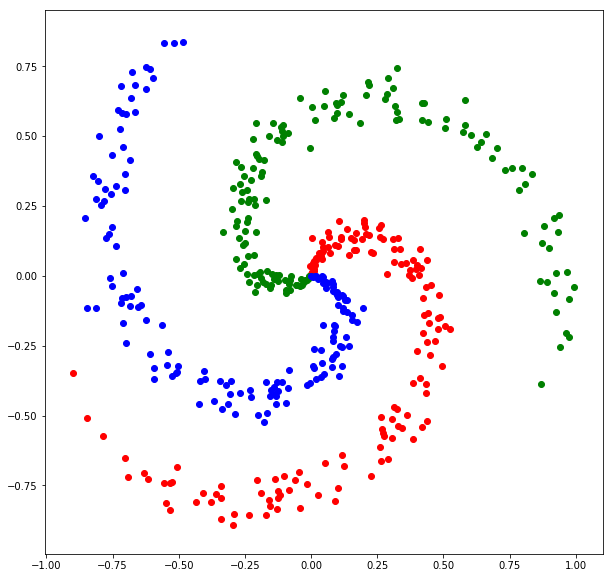

In [3]:
plt.scatter(x[:150, 0], x[:150, 1], color='r')
#plt.hold('on')
plt.scatter(x[150:300, 0], x[150:300, 1], color='g')
plt.scatter(x[300:450, 0], x[300:450, 1], color='b')

fig = plt.gcf()
fig.set_size_inches(10, 10)

plt.show()

In [4]:
x.shape, y.shape

((450, 2), (450, 3))

In [5]:
indices = np.arange(batch * classes)
random_state.shuffle(indices)

x_train = x[indices[:300]]
y_train = y[indices[:300]]
x_test = x[indices[300:]]
y_test = y[indices[300:]]

Define the multi-layer perceptron with 2 hidden layers

In [6]:
num_hidden1 = 50
num_hidden2 = 50
reg = 1e-3

tni = initializers.TruncatedNormalInitializer(mean=0.0, stddev=0.01, seed=0)
zi = initializers.ZerosInitializer()
gd = optimizers.GradientDescentOptimizer(alpha=0.1)

inputs = ad.placeholder([None, features])
labels = ad.placeholder([None, classes])

weight1 = ad.variable((features, num_hidden1), tni)
bias1 = ad.variable((num_hidden1,), zi)

weight2 = ad.variable((num_hidden1, num_hidden2), tni)
bias2 = ad.variable((num_hidden2,), zi)

weight3 = ad.variable((num_hidden2, classes), tni)
bias3 = ad.variable((classes,), zi)

hidden1 = ad.relu(ad.matmul(inputs, weight1) + bias1)
hidden2 = ad.relu(ad.matmul(hidden1, weight2) + bias2)
logits = ad.matmul(hidden2, weight3) + bias3

loss = ad.reduce_mean(ad.softmax_cross_entropy_loss(labels=labels, logits=logits))

r1 = ad.l2norm(weight1, reg)
r2 = ad.l2norm(weight2, reg)
r3 = ad.l2norm(weight3, reg)

loss = loss + r1 + r2 + r3

setup the graph and runtime

In [7]:
graph = ad.get_default_graph()
graph.initialize_variables()

runtime = ad.RunTime()
graph.set_runtime(runtime)

Training stage: run forward backward cycles on the computational graph.

In [8]:
feed_dict = {inputs: x_train, labels: y_train}
for i in range(10000):
  with runtime.forward_backward_cycle():
    gd.optimize(loss, feed_dict)

    if i % 1000 == 0:
      print('step: %d, loss: %f' % (i, loss.forward(feed_dict)))

step: 0, loss: 1.098719
step: 1000, loss: 1.095585
step: 2000, loss: 1.093743
step: 3000, loss: 0.661386
step: 4000, loss: 0.268614
step: 5000, loss: 0.144478
step: 6000, loss: 0.131555
step: 7000, loss: 0.127640
step: 8000, loss: 0.125688
step: 9000, loss: 0.124415


Evaluate on test set.

In [9]:
feed_dict = {inputs: x_test}

with runtime.forward_backward_cycle():
  logits_val = logits.forward(feed_dict)

print('accuracy:', np.mean(np.argmax(logits_val, axis=1) == np.argmax(y_test, axis=1)))

accuracy: 0.9933333333333333
